### Modelling maritime traffic on the Baltic Sea using a simple and more elaborate ship maneuvaribility

In [1]:
from pygradu import gridify
import shapely.geometry
import pandas as pd
import numpy as np
import importlib

grid = gridify.area_to_grid(side_length=5000)

Original NE: POINT (31.5 66.8)
Original SW: POINT (8.5 53)
Transformed NE: (697681.2863658136, 7416224.9393330095)
Transformed SW: (-735260.4063631196, 6033964.466017238)
col_count 286
row_count 276
grid_size 78936


In [22]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})
def visualize_graph(graph, grid):
    nodes = graph.original.values
    lats = []
    lons = []
    for node in nodes:
        latlon = grid.extract_coords_lat_lon(node)
        lats.append(latlon[0])
        lons.append(latlon[1])

    f = plt.figure(figsize=[50,50])
    m = Basemap(llcrnrlon = min(lons),llcrnrlat = min(lats), urcrnrlon = max(lons),
               urcrnrlat = max(lats),
               resolution='l')
    m.shadedrelief()

    plt.plot(lons, lats, 'o', c='red', alpha=0.03, markersize=4)

    plt.show()
    
def visualize_two_graphs(graph_bottom, graph_top, grid):
    nodes = graph_bottom.original.drop_duplicates().values
    lats = []
    lons = []
    for node in nodes:
        latlon = grid.extract_coords_lat_lon(node)
        lats.append(latlon[0])
        lons.append(latlon[1])


    nodes = graph_top.original.values
    lats2 = []
    lons2 = []
    for node in nodes:
        latlon = grid.extract_coords_lat_lon(node)
        lats2.append(latlon[0])
        lons2.append(latlon[1])

    f = plt.figure(figsize=[52,52])
    m = Basemap(llcrnrlon = min(lons),llcrnrlat = min(lats), urcrnrlon = max(lons),
               urcrnrlat = max(lats),
               resolution='l')
    m.shadedrelief()

    plt.plot(lons, lats, 'o', c='blue', alpha=1, markersize=4)
    plt.plot(lons2, lats2, 'o', c='red', alpha=0.02, markersize=4)

    plt.show()
    
    
def visualize_graph_connections(graph, grid):
    rows = graph.drop_duplicates().values
    lats = []
    lons = []
    f = plt.figure(figsize=[60,60])
    for row in rows:
        original_latlon = grid.extract_coords_lat_lon(row[0])
        connected_latlon = grid.extract_coords_lat_lon(row[1])
        lats = [original_latlon[0], connected_latlon[0]]
        lons = [original_latlon[1], connected_latlon[1]]

        plt.plot(lons, lats, alpha=1, markersize=4, linewidth=2, c=np.random.rand(3,))


    m = Basemap(llcrnrlon = min(lons),llcrnrlat = min(lats), urcrnrlon = max(lons),
               urcrnrlat = max(lats),
               resolution='l')
    m.shadedrelief()

    plt.show()

In [3]:
# Import dataset

ais = pd.read_csv('training_set.csv', index_col=0, parse_dates = ['timestamp'])
ais = ais.sort_values(by=['mmsi', 'timestamp'])
ais.head()

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


timestamp       mmsi        lat        lon  speed  course  \
20219 2017-11-02 11:19:07  205366000  54.347242   9.991140   4.01    56.6   
20220 2017-11-02 11:30:58  205366000  54.360348  10.025337   4.17    77.5   
20221 2017-11-02 11:37:58  205366000  54.359573  10.049203   4.48    92.4   
20222 2017-11-02 11:44:07  205366000  54.365497  10.071320   3.81    44.9   
20223 2017-11-02 11:56:08  205366000  54.370437  10.109498   2.73   103.6   

       heading  turnrate  vessel_id  vessel_src  breadth vessel_type  \
20219     56.0       0.0       3204           2    21.33           T   
20220     81.0       0.0       3204           2    21.33           T   
20221     92.0       0.0       3204           2    21.33           T   
20222     46.0       0.0       3204           2    21.33           T   
20223    103.0       0.0       3204           2    21.33           T   

       vessel_max_speed  draft   power  length      dwt iceclass verified  
20219              16.0   8.18  5820.0  143.18  13289.0       IA        N  
20220              16.0   8.18  5820.0  143.18  13289.0       IA        N  
20221              16.0   8.18  5820.0  143.18  13289.0       IA        N  
20222              16.0   8.18  5820.0  143.18  13289.0       IA        N  
20223              16.0   8.18  5820.0  143.18  13289.0       IA        N

In [4]:
# Remove unnecessary columns
%time ais_subset = ais[['timestamp', 'mmsi', 'lat', 'lon']]
len(ais_subset)

CPU times: user 189 ms, sys: 89.3 ms, total: 278 ms
Wall time: 279 ms


14185046

In [5]:
%time ais_subset['grid_point'] = ais_subset.apply(lambda row: grid.get_grid_point(row.lat, row.lon), axis=1)

CPU times: user 7min 15s, sys: 5.73 s, total: 7min 21s
Wall time: 7min 22s


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [6]:
%time ais_subset['node'] = ais_subset.apply(lambda row: grid.get_grid_position(row), axis=1)

CPU times: user 8min 25s, sys: 24 s, total: 8min 49s
Wall time: 9min


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
ais_subset = ais_subset[['timestamp', 'mmsi', 'lat', 'lon', 'node']]
ais_subset.head()

timestamp       mmsi        lat        lon  node
20219 2017-11-02 11:19:07  205366000  54.347242   9.991140  6650
20220 2017-11-02 11:30:58  205366000  54.360348  10.025337  6651
20221 2017-11-02 11:37:58  205366000  54.359573  10.049203  6651
20222 2017-11-02 11:44:07  205366000  54.365497  10.071320  6651
20223 2017-11-02 11:56:08  205366000  54.370437  10.109498  6652

### Model movement options using adjacent model

In [8]:
importlib.reload(gridify)

%time traffic_graph_adjacent = gridify.create_graph_from_ais_adjacent(ais_subset)
graph_cols = ['original', 'connected']
traffic_graph_adjacent = pd.DataFrame(traffic_graph_adjacent, columns=graph_cols)
traffic_graph_adjacent.head(5)

CPU times: user 21min 52s, sys: 41 s, total: 22min 33s
Wall time: 30min 44s


original  connected
0      6650       6651
1      6651       6652
2      6652       6653
3      6653       6930
4      6930       7207

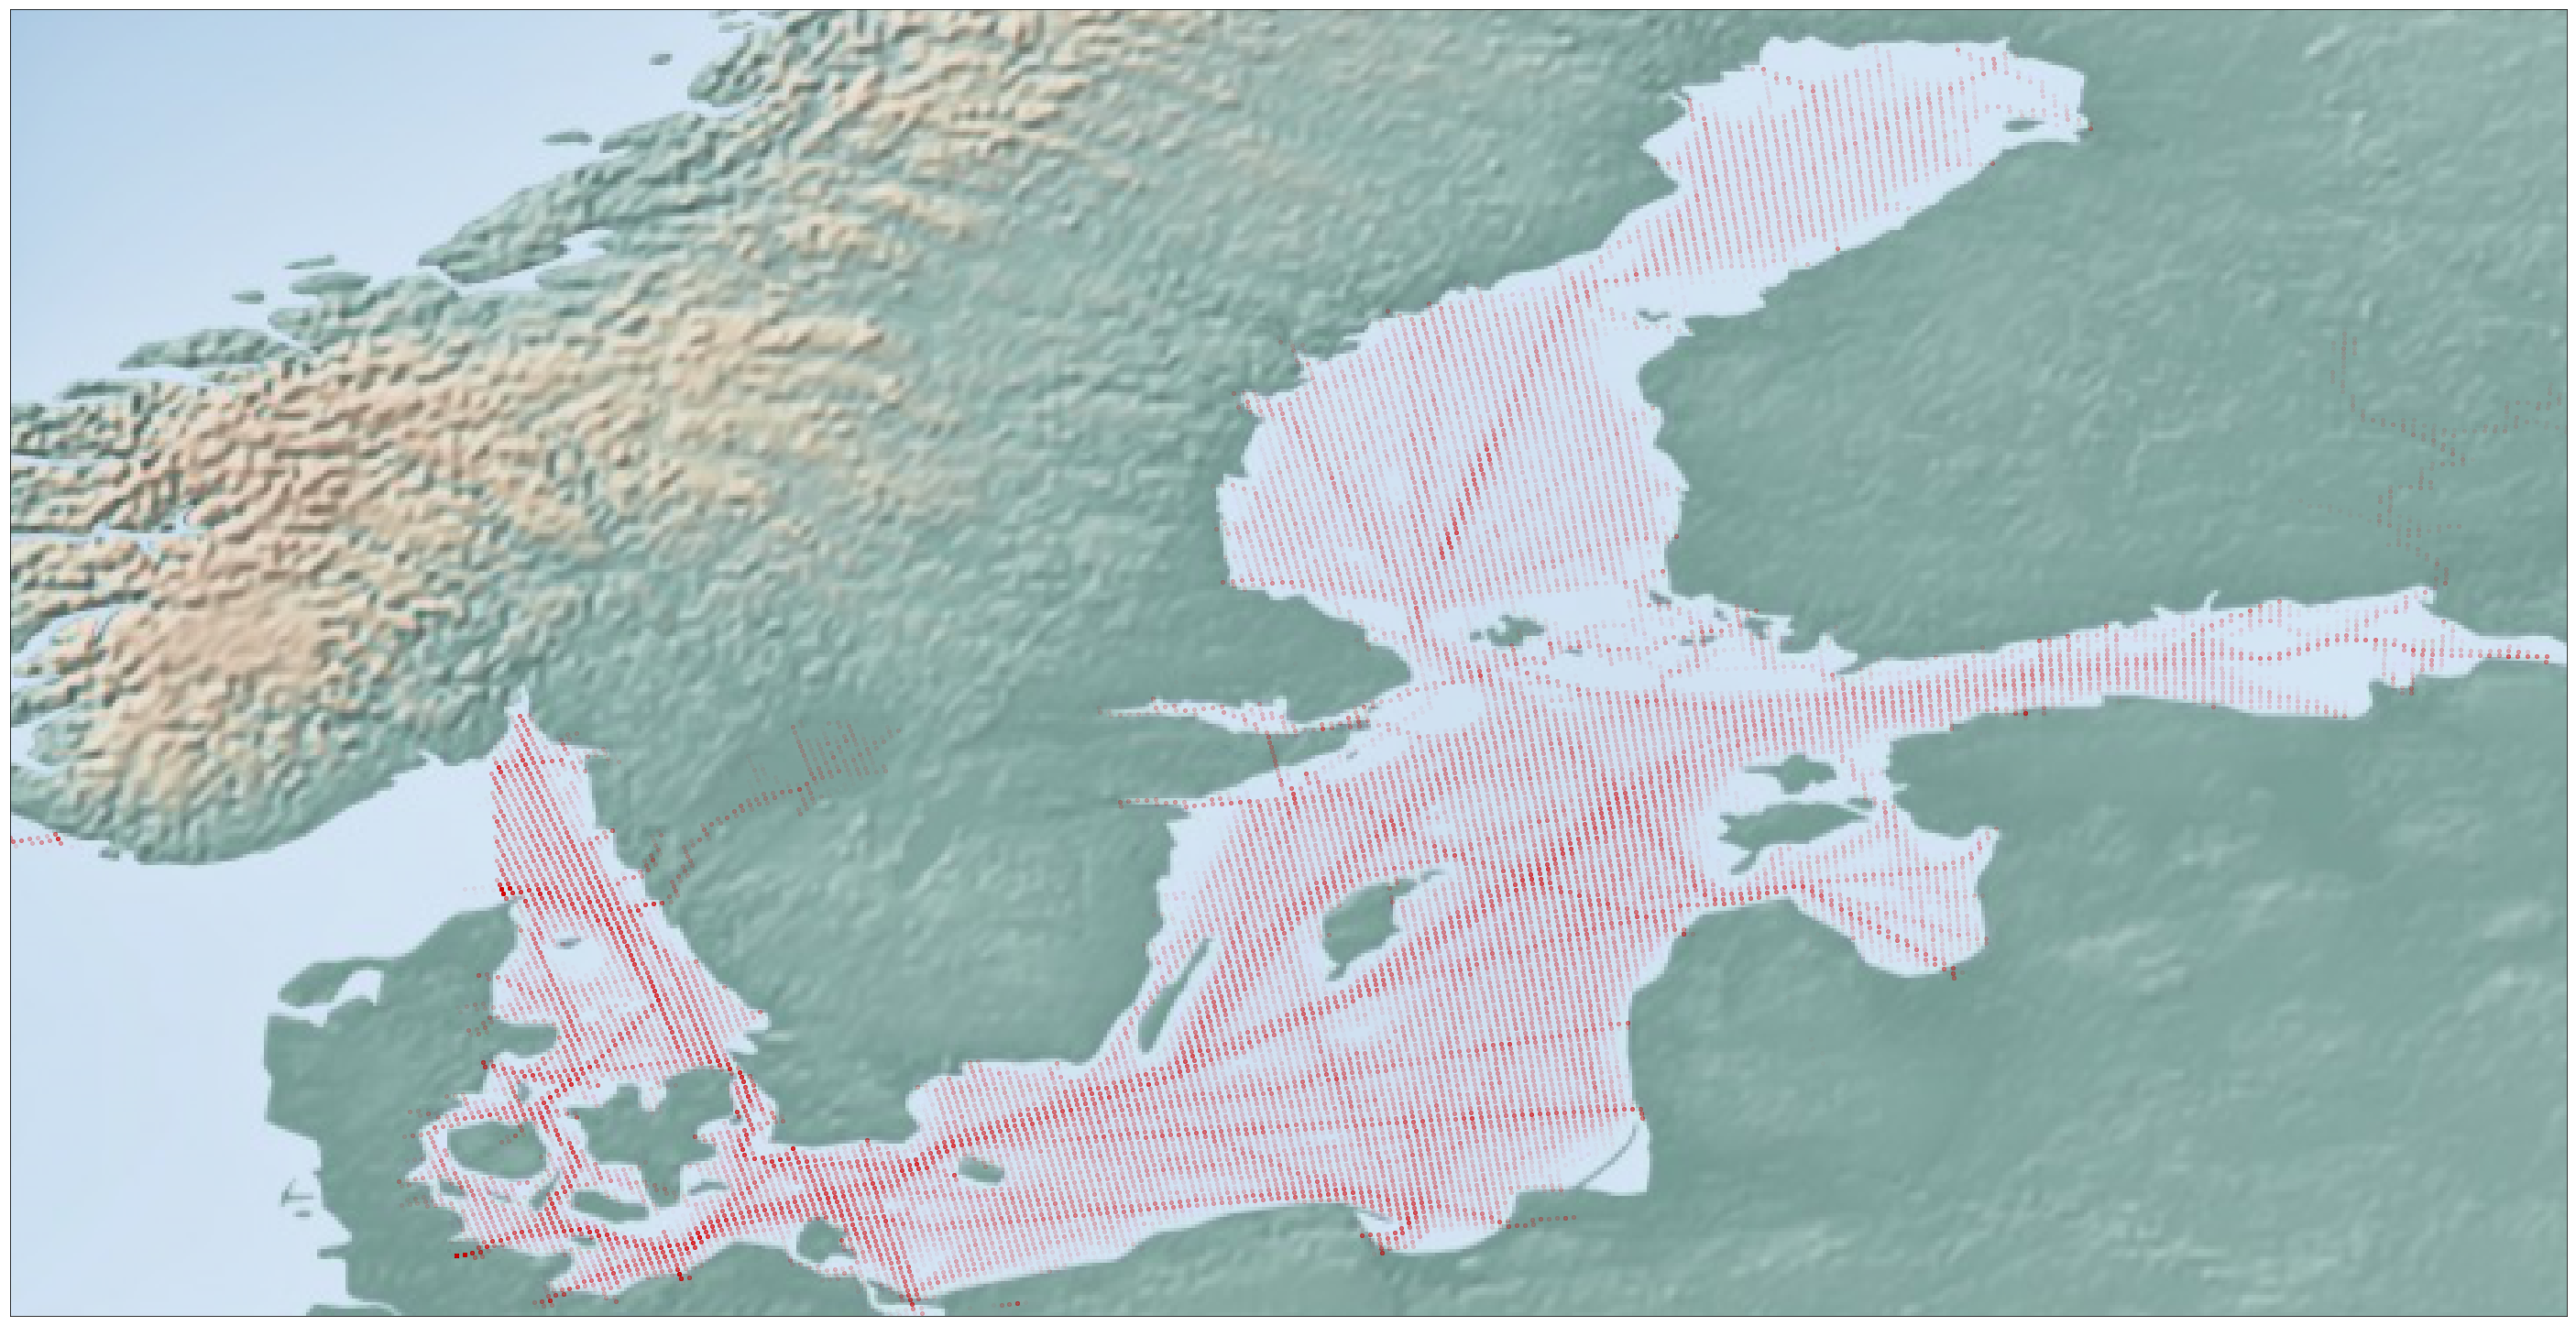

In [20]:
visualize_graph(traffic_graph_adjacent.drop_duplicates(), grid)

### Remove impossible connections

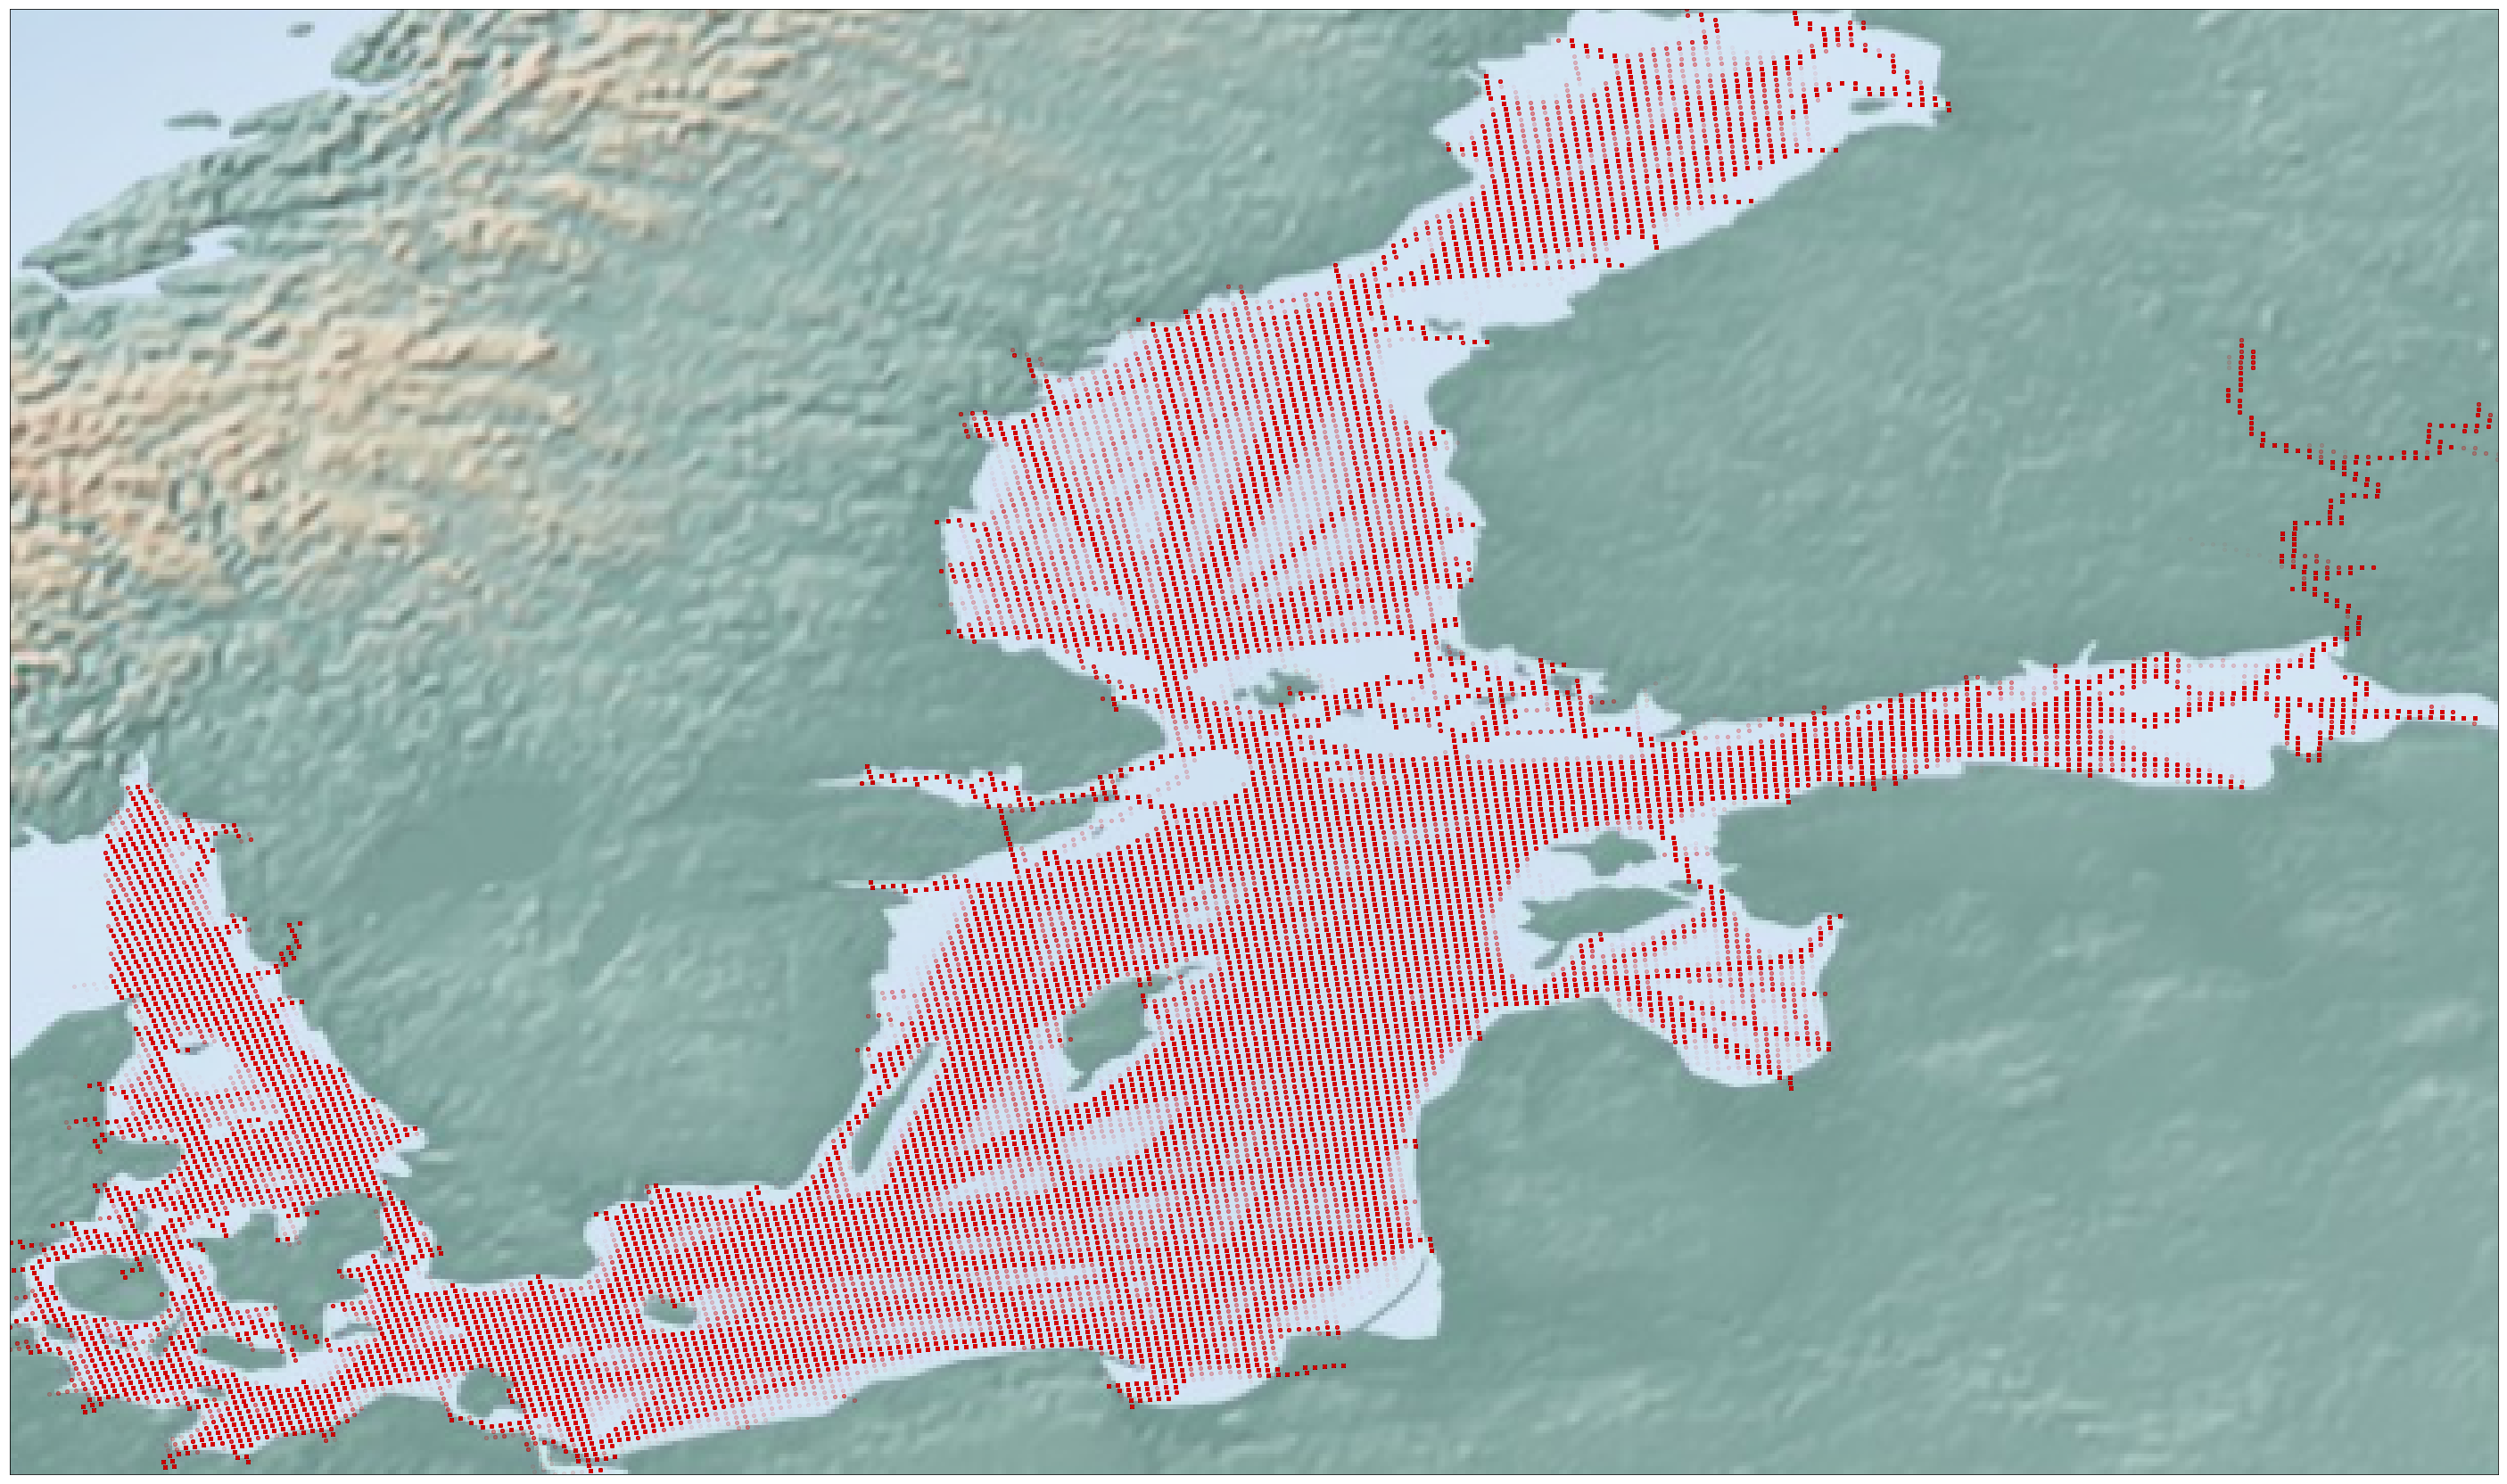

In [21]:
sea_graph = pd.read_csv('data/models/sea_model_5km_adjacent.csv')

originals = set(sea_graph.original.drop_duplicates().values)
traffic_graph_adjacent = traffic_graph_adjacent[traffic_graph_adjacent.original.isin(originals) & traffic_graph_adjacent.connected.isin(originals)]
visualize_graph(traffic_graph_adjacent, grid)

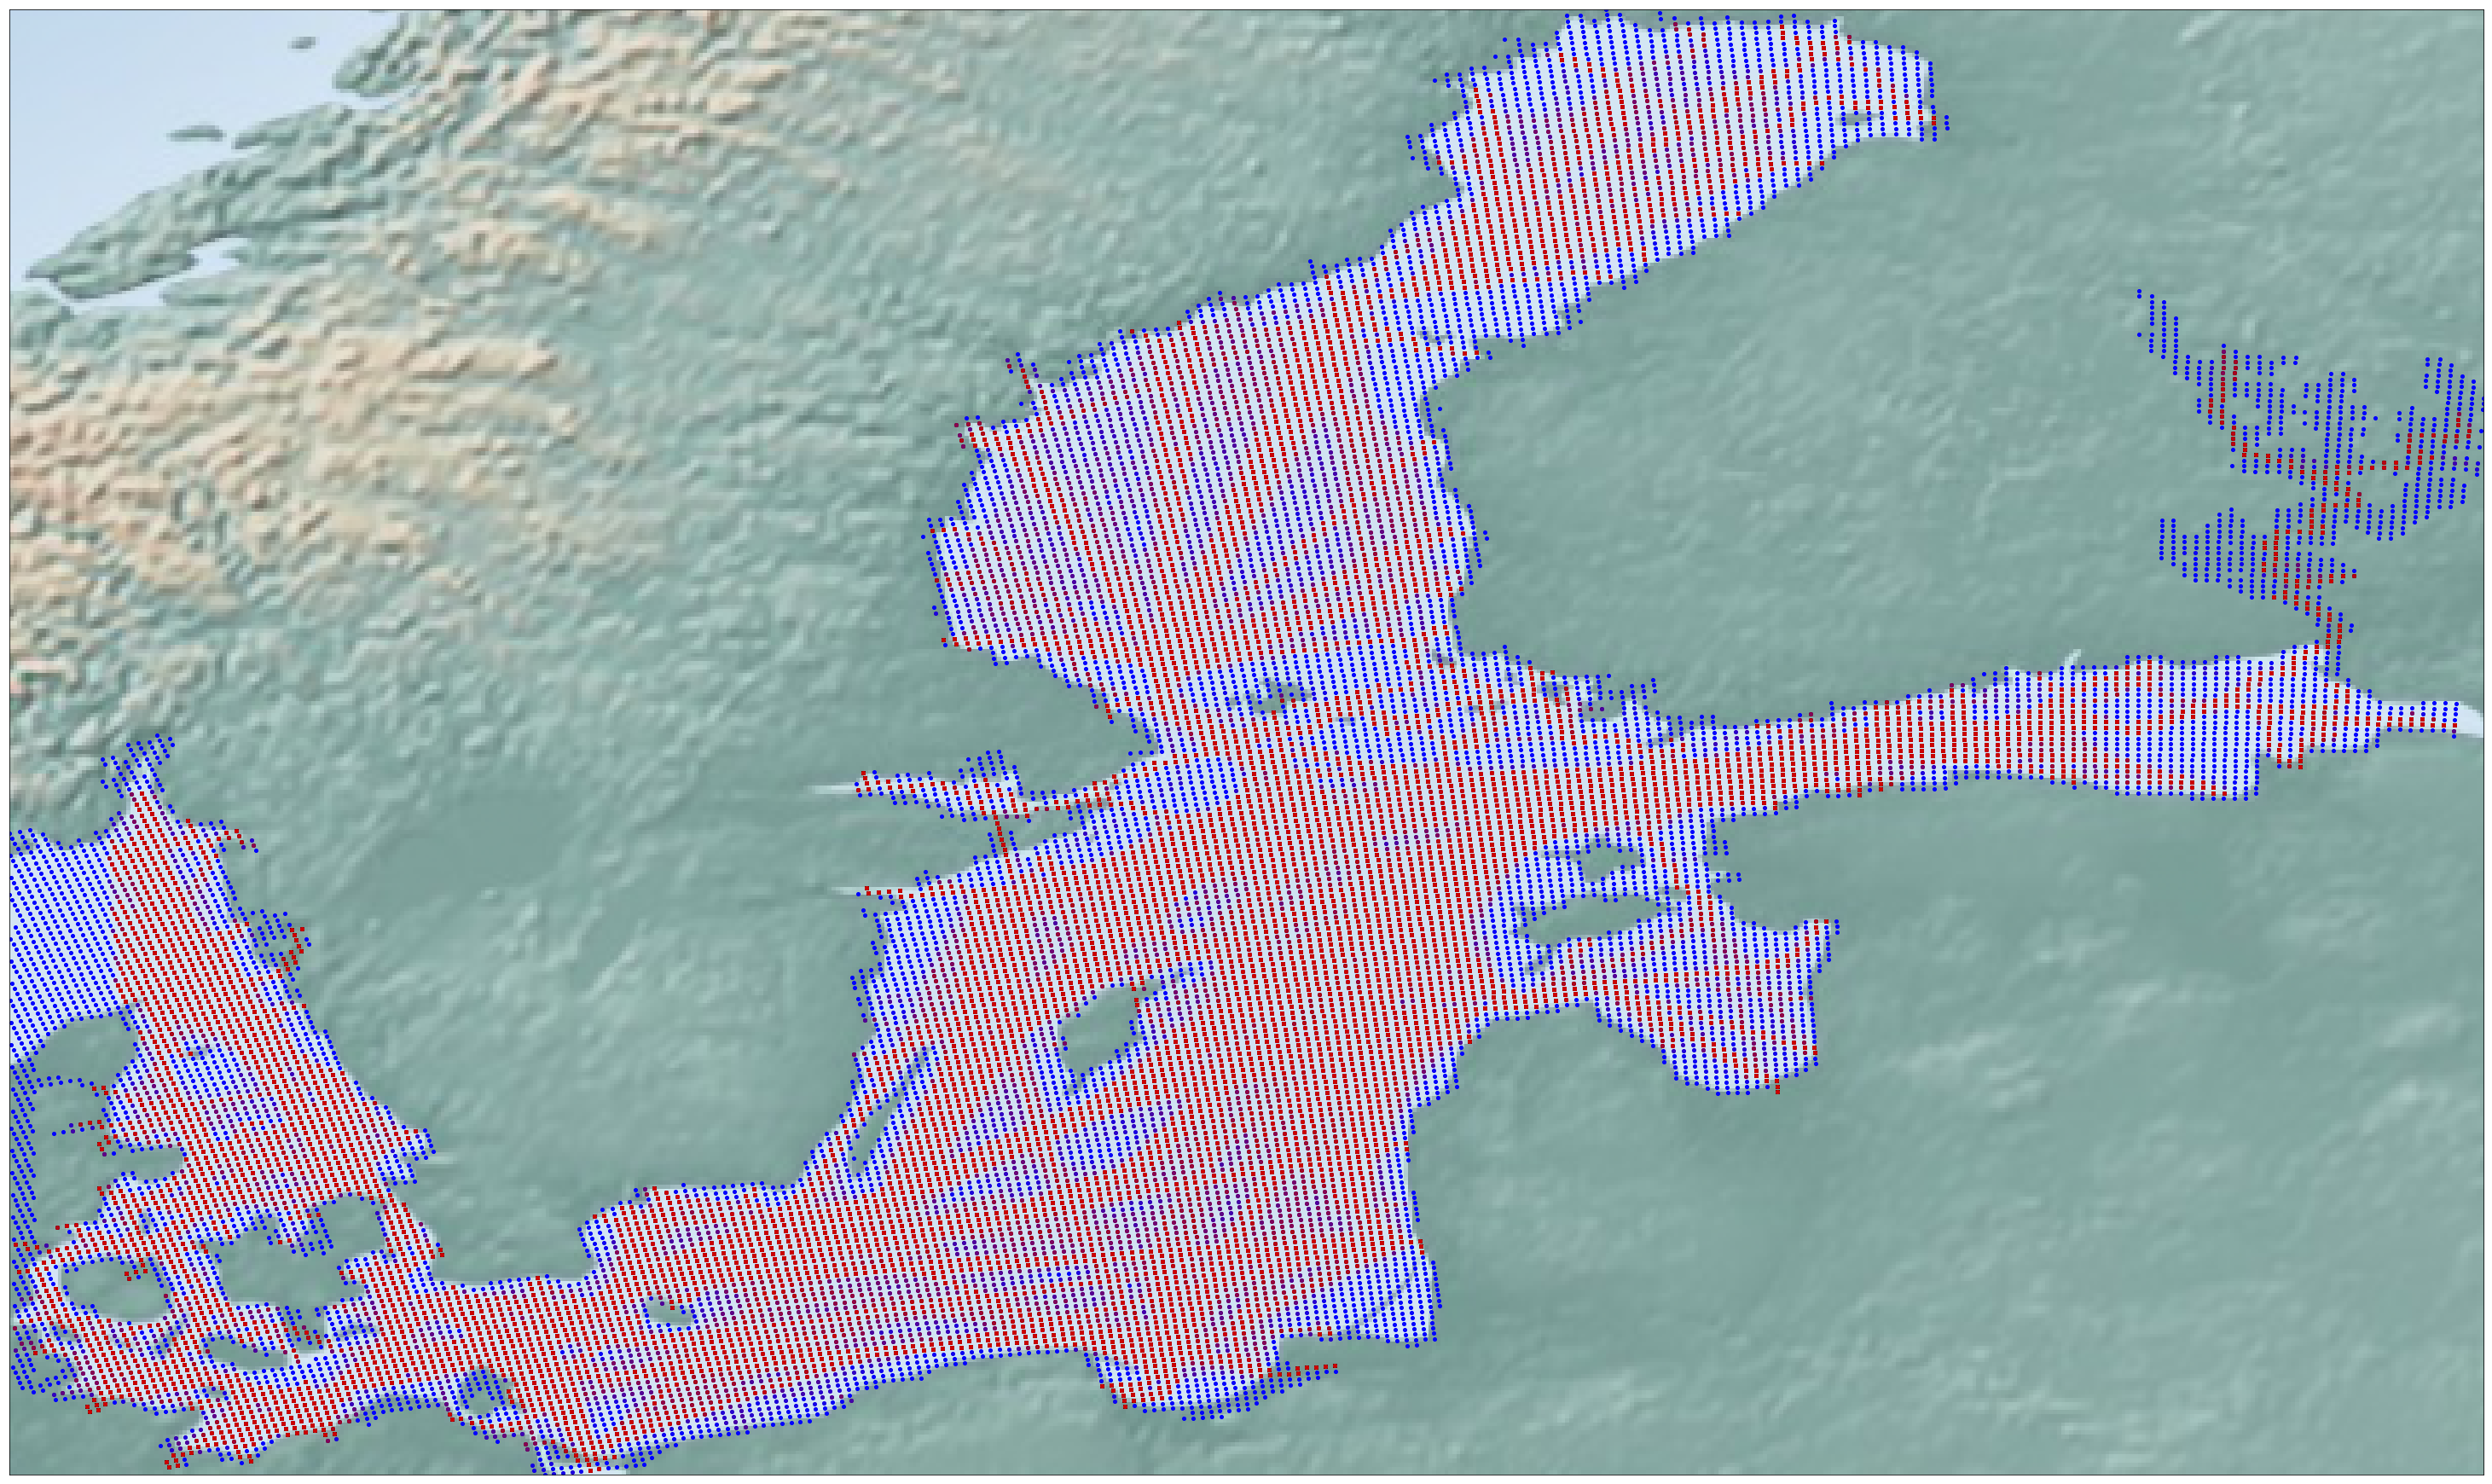

In [23]:
visualize_two_graphs(sea_graph, traffic_graph_adjacent, grid)